### Query 
make $i_{mag} < 18$
~~~
    SELECT *
    FROM mean_param
    JOIN magnitudes ON mean_param.iau_name = magnitudes.iau_name
    WHERE magnitudes.i < 18;
~~~

In [24]:
import csv
import lightkurve as lk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import numpy as np
import astropy.units as u
from astropy.modeling.models import Sine1D
from sklearn.linear_model import LinearRegression
import pandas as pd
from astropy.modeling import models, fitting

In [2]:
palette = sns.color_palette()
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
# Make query seperated by commas instead of spaces
with open('og_test_query.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')

    with open('comma_test_query.csv', 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        
        # Iterate through each row
        for row in reader:
            # Replace spaces for commas for each element
            modified_row = [column.replace(' ', ',') for column in row]
            
            writer.writerow(modified_row)

In [104]:
df = pd.read_csv('comma_test_query.csv')

all_df = df[['iau_name', 'i', 'porb', 'porbe']]
porb_df = all_df[all_df['porb'] != 0].reset_index()
no_porb_df = all_df[all_df['porb'] == 0].reset_index()

print(porb_df)
print(no_porb_df)

    index                 iau_name        i       porb         porbe
0      18  SDSSJ005245.11-005337.2  17.9716   2.735000  2.000000e-03
1      23  SDSSJ011009.09+132616.1  17.0235   7.984495  3.000000e-06
2      30  SDSSJ013851.54-001621.6  15.8900   1.746529  1.000000e-09
3      33  SDSSJ015225.38-005808.5  16.9841   2.151947  9.900000e-06
4      44  SDSSJ023804.39-000545.7  17.6982   5.080100  4.800000e-03
..    ...                      ...      ...        ...           ...
58    899  SDSSJ162354.45+630640.4  17.3778  53.562400  3.400000e-03
59    906  SDSSJ184412.58+412029.4  15.6925   5.416600  1.000000e-03
60    914  SDSSJ224307.59+312239.1  17.2834   2.870300  5.900000e-03
61    919  SDSSJ231105.66+220208.6  17.4523  13.922400  1.700000e-03
62    924  SDSSJ013532.97+144555.9  17.1633   1.698000  1.200000e+00

[63 rows x 5 columns]
     index                 iau_name         i  porb  porbe
0        0  SDSSJ000152.09+000644.7  17.50190   0.0    0.0
1        1  SDSSJ001339.10+0019

### Orbital Period Found

In [105]:
porb_df.iloc[0]

index                            18
iau_name    SDSSJ005245.11-005337.2
i                           17.9716
porb                          2.735
porbe                         0.002
Name: 0, dtype: object

In [106]:
star_result = lk.search_lightcurve(porb_df.iloc[0]['iau_name'], mission='TESS')
star_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 70,2023,SPOC,120,333640393,0.0


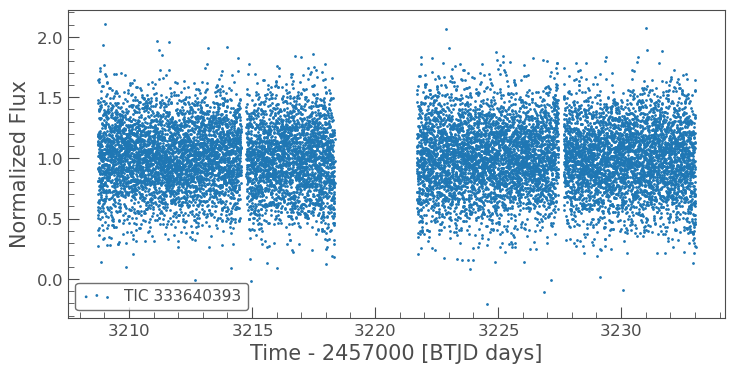

In [9]:
star_lightcurve = star_result[0].download().remove_nans().remove_outliers().normalize()
star_lightcurve.scatter(color=palette[0])
plt.show()

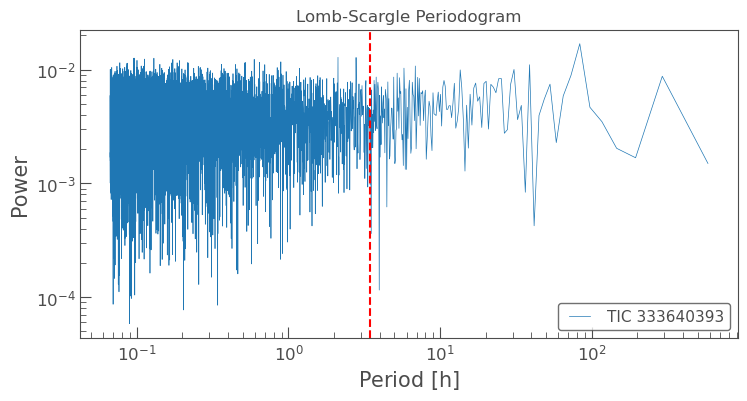

In [10]:
star_periodogram = star_lightcurve.to_periodogram(oversample_factor=1)
star_periodogram.plot(color=palette[0], view='period', scale='log', unit=u.hr)
plt.axvline(x=star_periodogram.period_at_max_power.value, color='red', linestyle='--')
plt.title('Lomb-Scargle Periodogram')
plt.show()

In [16]:
best_period = star_periodogram.period_at_max_power
star_periodogram.period, star_periodogram.power, star_periodogram.period_at_max_power

(<Quantity [2.42944826e+01, 1.21472413e+01, 8.09816086e+00, ...,
            2.77873528e-03, 2.77841750e-03, 2.77809978e-03] d>,
 <Quantity [0.001496  , 0.00872794, 0.00167811, ..., 0.00392877, 0.00382947,
            0.00185728]>,
 <Quantity 3.47064037 d>)

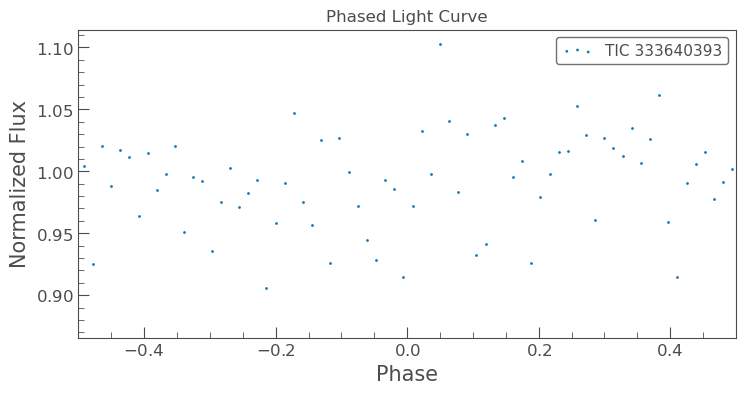

In [91]:
phase_lightcurve = star_lightcurve.fold(period=best_period)
binned_lightcurve = phase_lightcurve.bin(20*u.min)
binned_lightcurve.scatter(color=palette[0])
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Phased Light Curve')
plt.xlim(-0.5, 0.5)
plt.show()

In [83]:
# Extract binned flux
time = binned_lightcurve.phase.value
flux = binned_lightcurve.flux

sine_model = models.Sine1D()
fitter = fitting.LevMarLSQFitter()
fitted_model = fitter(sine_model, time, flux)
fitted_model

<Sine1D(amplitude=0.18208052 , frequency=1.00455154 , phase=-0.24967639)>

$y(t)=Asin(2πft+ϕ)$ \
Where: \
$y(t)$ is the displacement or amplitude of the wave at time $t$ \
$A$ is the amplitude \
$f$ is the frequency (the number of cycles per second, measured in Hertz) \
$\phi$ is the phase (the initial position of the wave, measured in radians) \
$t$ is the time variable

<Figure size 1000x600 with 0 Axes>

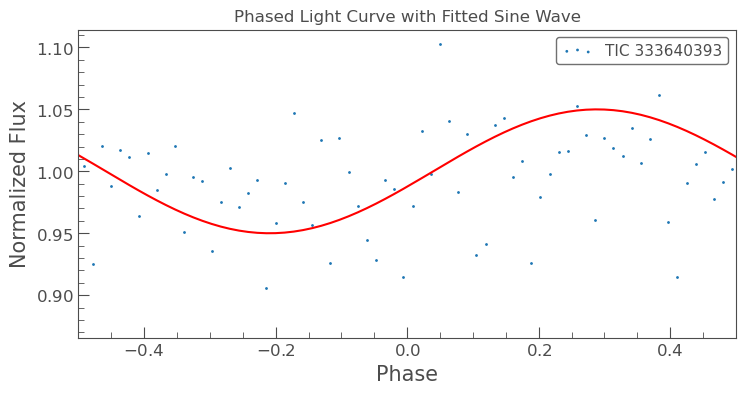

In [100]:
# Extract the fitted parameters
amplitude = fitted_model.amplitude.value
frequency = fitted_model.frequency.value
phase = fitted_model.phase.value
offset = 1

fitted_flux = 0.05 * np.sin((2 * np.pi * frequency * time) + phase) + offset
 
# Plot the phased light curve with the fitted sine wave
plt.figure(figsize=(10, 6))
binned_lightcurve.scatter(color=palette[0])
plt.xlim(-0.5, 0.5)
plt.plot(time, fitted_flux, color='r')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Phased Light Curve with Fitted Sine Wave')
plt.show()

In [107]:
porb_df.iloc[1]

index                            23
iau_name    SDSSJ011009.09+132616.1
i                           17.0235
porb                       7.984495
porbe                      0.000003
Name: 1, dtype: object

In [108]:
star_result = lk.search_lightcurve(porb_df.iloc[1]['iau_name'], mission='TESS')
star_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 42,2021,SPOC,20,408253347,0.0
1,TESS Sector 43,2021,SPOC,20,408253347,0.0
2,TESS Sector 42,2021,SPOC,120,408253347,0.0
3,TESS Sector 43,2021,SPOC,120,408253347,0.0
4,TESS Sector 70,2023,SPOC,20,408253347,0.0
5,TESS Sector 70,2023,SPOC,120,408253347,0.0
6,TESS Sector 42,2021,TESS-SPOC,600,408253347,0.0
7,TESS Sector 43,2021,TESS-SPOC,600,408253347,0.0


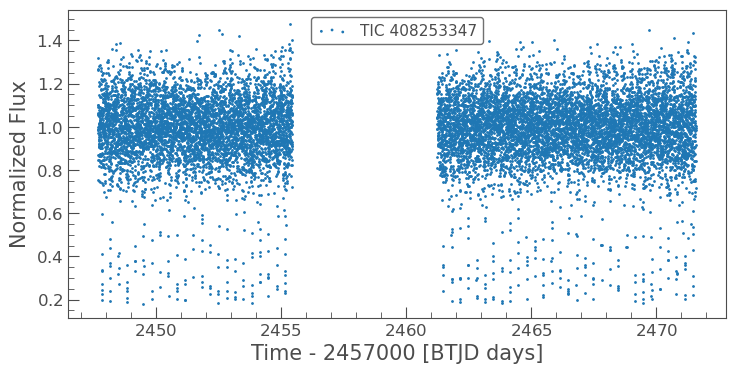

In [109]:
star_lightcurve = star_result[2].download().remove_nans().remove_outliers().normalize()
star_lightcurve.scatter(color=palette[0])
plt.show()

/Users/bella/anaconda3/envs/pceb_ob_ENV/lib/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


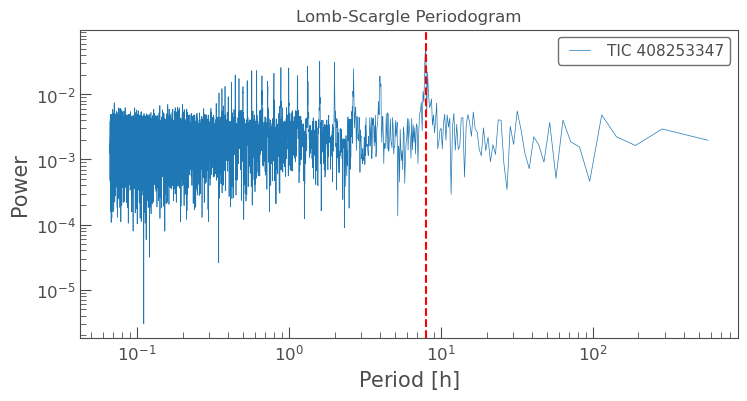

In [123]:
star_periodogram = star_lightcurve.to_periodogram(oversample_factor=1)
star_periodogram.plot(color=palette[0], view='period', scale='log', unit=u.hr)
plt.axvline(x=7.984495, color='red', linestyle='--')
plt.title('Lomb-Scargle Periodogram')
plt.show()

In [124]:
best_period = 7.984495
star_periodogram.period, star_periodogram.power, star_periodogram.period_at_max_power

(<Quantity [2.38792791e+01, 1.19396396e+01, 7.95975971e+00, ...,
            2.77859892e-03, 2.77827564e-03, 2.77795243e-03] d>,
 <Quantity [0.00197234, 0.00294249, 0.00163948, ..., 0.00256466, 0.00175263,
                   nan]>,
 <Quantity 0.33165665 d>)

In [139]:
phase_lightcurve = star_lightcurve.fold(period=best_period)
binned_lightcurve = phase_lightcurve.to_binned_time(bin_width=6*u.min)

# Create the vertical lines
x = binned_lightcurve.time.value
y1 = binned_lightcurve.flux - binned_lightcurve.flux_err
y2 = binned_lightcurve.flux + binned_lightcurve.flux_err

plt.vlines(x, y1, y2, color=palette[0], lw=2)

plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Phased Light Curve')
plt.xlim(-0.5, 0.5)
plt.show()

AttributeError: object has no attribute to_binned_time